In [1]:
%load_ext autoreload
%autoreload 2

In [88]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from tifffile import imread

datapath = Path.cwd().parent / "data"
tracking_path = datapath / "interim" / "tracking"

In [67]:
from src.utils import tracklet_from_path

root = "drift"
spots, edges, tracks, tracklets = tracklet_from_path(tracking_path, root)

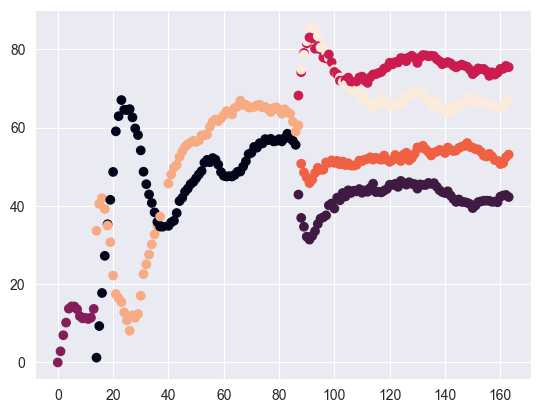

In [82]:
# visualize a single lineage tree
track = spots[spots["TRACK_ID"] == spots["TRACK_ID"].unique()[3]]
track = track.sort_values(by="FRAME")
distance_from_origin = np.sqrt((track["POSITION_X"] - track["POSITION_X"].iloc[0])**2 + (track["POSITION_Y"] - track["POSITION_Y"].iloc[0])**2)

plt.scatter(track["FRAME"], distance_from_origin, c=track["TRACKLET_ID"])

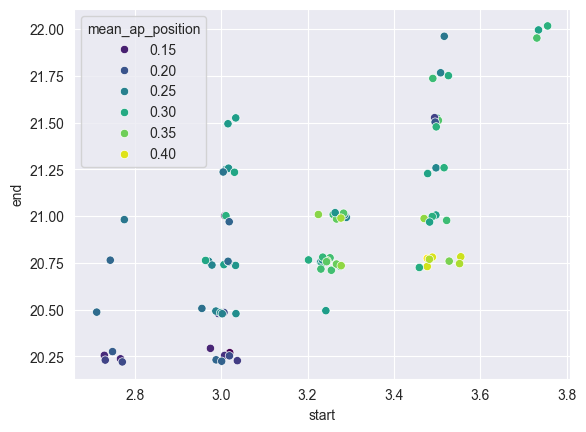

In [117]:
x_a, y_a = 345, 147
x_b, y_b = 2358, 2325
x, y = spots["POSITION_X"] - x_a, spots["POSITION_Y"] - y_a
x_ref, y_ref = x_b - x_a, y_b - y_a

spots["ap_position"] = (x*x_ref + y*y_ref)/(x_ref**2 + y_ref**2)

tracklets["mean_ap_position"] = tracklets.index.map(spots.groupby("TRACKLET_ID")["ap_position"].mean())

def jitter(values):
    return values + np.random.normal(0,0.08,values.shape)

first_gen = tracklets[tracklets["start"].between(10, 16) & tracklets["end"].between(60, 100)]

sns.scatterplot(x = jitter(first_gen.start)/4, y = jitter(first_gen.end)/4, hue=first_gen["mean_ap_position"], palette="viridis")
plt.show()